# Dual Task Effect (DTE)
---
[2024.07/28] V1 created  

## Configurations
First, you need to configurate several options
- how are you raw datas? One csv per participants, or all together? See the different structures in ~/sample
- what do you want to save? One csv per participants, or all together? Do you also want the plot?
- what are the directions of your cognitive and motor tests? Does higher values means better or worst performance? In our synthetic exemple values, we considered 
    - "Cognitive" : Stroop test correct answers rate -> higher values = better performance
    - "Motor" : Timed Up-and-go test -> higher values = worst performance

In [51]:
# Set this to True if you have one CSV file for all subjects, or False if you have one CSV per subject
allTogether = True

# Set this to True if you want to save on report for all participants
saveAllTogether = True
# Set this to True if you want to save on report per participants
saveIndependent = False

# Set this to True if you want to save the final plot
savePlot = True

# Configuration for performance directionality of the evaluation tests
# True = higher values are better, False = lower values are better
performance_directionality = {
    "Cognitive": True,
    "Motor": False
}

# Needed libraries to import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define the input path (~/sample)
path = os.path.join(os.getcwd(), 'sample')  # Path containing all .csv files
# Define the saving path (~/results)
results_path = os.path.join(os.getcwd(), 'results')
os.makedirs(results_path, exist_ok=True)


## Importing the data
We then import the data - one by one, or all together depending on the way `allTogether` was defined. We also check for any missing data, and print the correct import.

In [52]:
# Function to check for missing values in a DataFrame and print their locations
def check_missing_values(df, file_name):
    if df.isnull().values.any():
        print(f"Missing values found in {file_name}:")
        missing_values = df[df.isnull().any(axis=1)]
        for idx, row in missing_values.iterrows():
            missing_cols = row[row.isnull()].index.tolist()
            for col in missing_cols:
                print(f"  Missing value at ID: {row['ID']}, Column: {col}")
    else:
        print(f"No missing values in {file_name}")

# Function to load data from a single CSV file
def load_single_csv(file_path):
    df = pd.read_csv(file_path)
    check_missing_values(df, file_path)
    return df

# Function to load data from multiple CSV files in a directory
def load_multiple_csvs(path):
    csv_files = [file_name for file_name in os.listdir(path) if file_name.endswith('.csv')]
    data_dict = {}
    for file_name in csv_files:
        file_path = os.path.join(path, file_name)
        df = pd.read_csv(file_path).T  # Transpose the DataFrame
        df = df.reset_index(drop=False)
        new_cols = df.iloc[0].tolist()
        df = df.rename(columns=dict(zip(df.columns, new_cols)))
        df = df.drop(df.index[0])
        check_missing_values(df, file_name)
        data_dict[file_name] = df
    return data_dict

# Load data
if allTogether:
    # Load data from a single CSV file
    data_file = 'data.csv'
    data_file_path = os.path.join(path, data_file)
    if os.path.exists(data_file_path):
        df_all = load_single_csv(data_file_path)
        data_dict = {f"00{id}": df for id, df in df_all.groupby('ID')}
        print(f"1 .csv file imported from {data_file} - OK")
    else:
        print(f"{data_file} not found in the specified directory.")
else:
    # Load data from multiple CSV files
    csv_files = [file_name for file_name in os.listdir(path) if file_name.endswith('.csv')]
    data_dict = load_multiple_csvs(path)
    if len(csv_files) == len(data_dict):
        print(f"{len(csv_files)} .csv files imported - OK")
    else:
        print(f"Problem: {len(csv_files)} .csv files found but only {len(data_dict)} imported")


No missing values in /Users/mgg/Documents/GitHub/DualTaskEffect/sample/data.csv
1 .csv file imported from data.csv - OK


In [53]:
# Displaying one subject, for the exemple
data_dict['001']


,ID,Single Task - Cognitive performance,Single Task - Motor performance,Dual Task - Cognitive performance,Dual Task - Motor performance
0,1,14.978987,15.448203,21.138984,17.903505


## Computing
It is now time for computation. Here, we calculate the Dual Task Effect (DTE), using the formula
$$
\text{DTE} = \frac{\text{DT} - \text{ST}}{\text{ST}} \times 100
$$
and caracterise it according to Plummer et al, 2013 ([DOI: 10.1155/2014/538602](https://onlinelibrary.wiley.com/doi/10.1155/2014/538602))  

![Figure Plummer et al. 2013](/Users/mgg/Documents/GitHub/DualTaskEffect/images/DTE.jpg)


In [54]:
# Creating the functions, with automatic task (Cognitive, Motor) detection
# Dual Task Effect
def calculate_dual_task_effect(df, task_type):
    single_task_col = f"Single Task - {task_type} performance"
    dual_task_col = f"Dual Task - {task_type} performance"
    effect_col = f"{task_type} Dual Task Effect"
    better_higher = performance_directionality[task_type]
    
    if single_task_col in df.columns and dual_task_col in df.columns:
        if better_higher:
            df[effect_col] = (df[dual_task_col] - df[single_task_col]) / df[single_task_col] * 100
        else:
            df[effect_col] = (df[single_task_col] - df[dual_task_col]) / df[single_task_col] * 100
    else:
        print(f"Columns for {task_type} not found in the DataFrame")
    
    return df


# Determine the DTE category (initial and final)
def determine_effect_category(cognitive_effect, motor_effect):
    if cognitive_effect > 0 and motor_effect == 0:
        return 'Cognitive facilitation'
    elif cognitive_effect > 0 and motor_effect > 0:
        return 'Mutual facilitation'
    elif motor_effect > 0 and cognitive_effect == 0:
        return 'Motor facilitation'
    elif motor_effect > 0 and cognitive_effect < 0:
        return 'Motor priority trade off'
    elif motor_effect == 0 and cognitive_effect < 0:
        return 'Cognitive interference'
    elif motor_effect < 0 and cognitive_effect < 0:
        return 'Mutual interference'
    elif motor_effect < 0 and cognitive_effect == 0:
        return 'Motor interference'
    elif cognitive_effect > 0 and motor_effect < 0:
        return 'Cognitive priority tradeoff'
    elif cognitive_effect == 0 and motor_effect == 0:
        return 'No interference'
    return 'Unknown'


# Apply the functions to each DataFrame in the dictionary
for key, df in data_dict.items():
    # DTE for Cognitive - percentage
    df = calculate_dual_task_effect(df, "Cognitive")
    # DTE for Motor - percentage
    df = calculate_dual_task_effect(df, "Motor")
    # DTE - category
    df["Dual Task Effect"] = df.apply(
        lambda row: determine_effect_category(row["Cognitive Dual Task Effect"], row["Motor Dual Task Effect"]),
        axis=1
    )
    
    data_dict[key] = df


## Saving and displaying the results
It is now time to save the results, as one document for all subjects or one per subjects depending on how `saveAllTogether` and `saveIndependent` are defined.

In [55]:
# Save independent files
if saveIndependent:
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    for key, value in data_dict.items():
        filename = os.path.join(results_path, f"{key}.csv")
        value.to_csv(filename, index=False)
    print(f"Saved {len(data_dict)} independent CSV files in {results_path}")

# Save concatenated file
if saveAllTogether:
    concatenated_df = pd.concat(data_dict.values(), axis=0)
    concatenated_df = concatenated_df.sort_values(by=['ID'])
    concatenated_filename = os.path.join(results_path, "concatenated_data.csv")
    concatenated_df.to_csv(concatenated_filename, index=False)
    print(f"Saved concatenated CSV file as {concatenated_filename}")


Saved concatenated CSV file as /Users/mgg/Documents/GitHub/DualTaskEffect/results/concatenated_data.csv


In [56]:
# Displaying the general results (5 first subjects)
concatenated_df.head()


,ID,Single Task - Cognitive performance,Single Task - Motor performance,Dual Task - Cognitive performance,Dual Task - Motor performance,Cognitive Dual Task Effect,Motor Dual Task Effect,Dual Task Effect
0,1,14.978987,15.448203,21.138984,17.903505,41.124259,-15.893771,Cognitive priority tradeoff
1,2,13.480289,19.578881,14.488541,14.752920,7.479452,24.648808,Mutual facilitation
2,3,15.442139,12.067792,11.146460,7.745180,-27.817900,35.819406,Motor priority trade off
3,4,11.903323,15.022998,7.755402,16.654646,-34.846753,-10.861003,Mutual interference
4,5,10.402516,15.414289,15.576375,18.255695,49.736608,-18.433580,Cognitive priority tradeoff


## Graphical representation
It's now time to represent every participants' DTP as a vector on the same plot, and to print the starting and stoping point according to Plummer et al., 2013. 

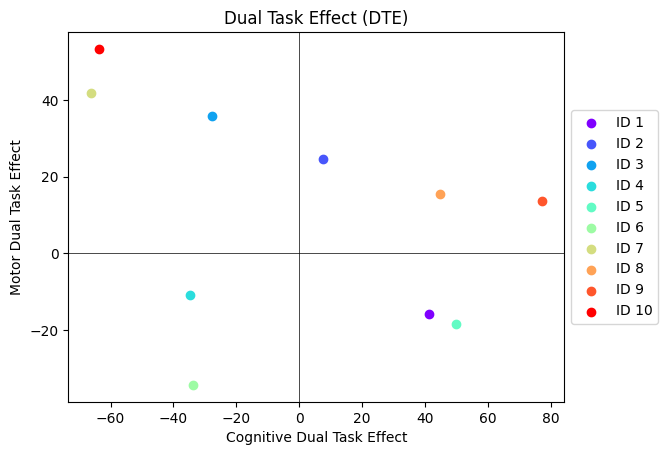

Participant 1    : Dual Task Effect (DTE) = Cognitive priority tradeoff
Participant 2    : Dual Task Effect (DTE) = Mutual facilitation
Participant 3    : Dual Task Effect (DTE) = Motor priority trade off
Participant 4    : Dual Task Effect (DTE) = Mutual interference
Participant 5    : Dual Task Effect (DTE) = Cognitive priority tradeoff
Participant 6    : Dual Task Effect (DTE) = Mutual interference
Participant 7    : Dual Task Effect (DTE) = Motor priority trade off
Participant 8    : Dual Task Effect (DTE) = Mutual facilitation
Participant 9    : Dual Task Effect (DTE) = Mutual facilitation
Participant 10   : Dual Task Effect (DTE) = Motor priority trade off


In [57]:
# Créer la figure et les axes
fig, ax = plt.subplots()

# Générer une colormap avec autant de couleurs qu'il y a d'ID uniques
num_colors = len(concatenated_df['ID'].unique())
colors = plt.cm.rainbow(np.linspace(0, 1, num_colors))

# Tracer un point pour chaque participant
for i, row in concatenated_df.iterrows():
    ax.scatter(row['Cognitive Dual Task Effect'], row['Motor Dual Task Effect'], color=colors[i % num_colors], label=f'ID {row["ID"]}')

# Ajouter des labels et des titres
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_title('Dual Task Effect (DTE)')
ax.set_xlabel('Cognitive Dual Task Effect')
ax.set_ylabel('Motor Dual Task Effect')

# Afficher la légende
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Afficher le graphique
plt.show()

# Imprimer les informations pour chaque participant
for i, row in concatenated_df.iterrows():
    print(f"Participant {row['ID']:<5}: Dual Task Effect (DTE) = {row['Dual Task Effect']}")


## Saving the plot

In [58]:
# Save or show the plot
if savePlot:
    results_path = os.path.join(os.getcwd(), 'results')
    plot_filename = os.path.join(results_path, 'DTE_plot.jpg')
    fig.savefig(plot_filename, format='jpg', bbox_inches='tight')
    print(f'{plot_filename} saved')
else:
    pass


/Users/mgg/Documents/GitHub/DualTaskEffect/results/DTE_plot.jpg saved
